# CDK2: evaluations using k conformations
## Data load and preprocessing

In [1]:
%run ./1_Helper_functions.ipynb

In [2]:
%load_ext rpy2.ipython

In [3]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

R_a = round(y.sum() / len(y), 2)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(3466, 402)
415
Ra = 0.12


## Estimators
### ML Classifiers

In [4]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified", "random_state": 42}
dclf = DummyClassifier(**hyparams)

In [5]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [6]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [7]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [8]:
# ML Classifier
ml_classifiers = {
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [9]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [10]:
estimators = {**ml_classifiers, **cs_functions}

In [11]:
full_names = ['1-NN', 'Log. Reg.', 'XGB', 'DummyClf', 'csMAX', 'csMEAN', 'csMIN', 'csVOTE']
new_names = dict(zip(estimators.keys(), full_names))

### Evaluation metrics 

In [12]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# Hold-out Validation

In [13]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def n_hold_out_validation_SAVE(filename, **kwargs):
    return n_hold_out_validation(**kwargs)


## k-random conformations

### 30 replicas


In [14]:
max_confs = 402
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, max_confs]
random_state=42

full_results = {}

## Random Selection

In [15]:
%%time

# ************
test_name = 'random'
full_results[test_name] = {}
# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    
    results = n_hold_out_validation_RANDOM_CONFS_SAVE(
                                            filename, n_reps, k, max_confs, 
                                            X, y, metrics, random_state)
        
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = results


File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-256
Evaluation with k=256 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_cdk2_nConfs-402
Evaluation with k=402 fi

### ROC-AUC

In [16]:
df_random = get_group_stats(full_results[test_name], metric_name='roc_auc', indexes_values=k_values)
df_random = df_random.replace(new_names)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Registering fonts with R

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: 
Attaching package: ‘plyr’


R[write to console]: The following objects are 

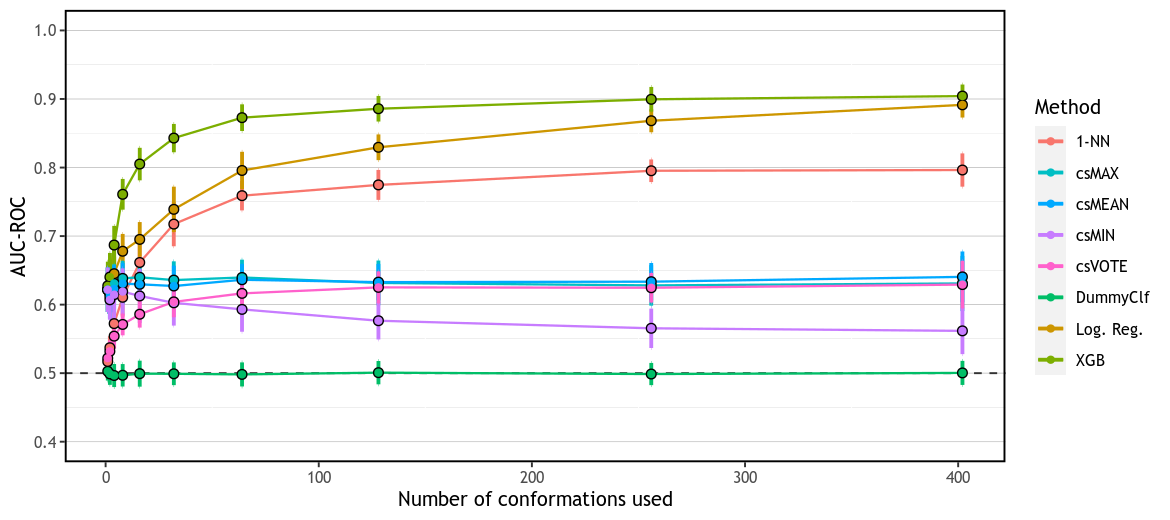

In [17]:
%%R -i full_names -i df_random  -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')
metric_name <- 'AUC-ROC'

df <- df_random
cbbPalette <- hue_pal()(8)
names(cbbPalette) <- full_names

plot_lines(df, cbbPalette, y_min=0.4, y_max=1., line_size=0.6,
               y_label=metric_name, base_h_line=0.5, switch_x=FALSE, 
               x_label="Number of conformations used") 

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



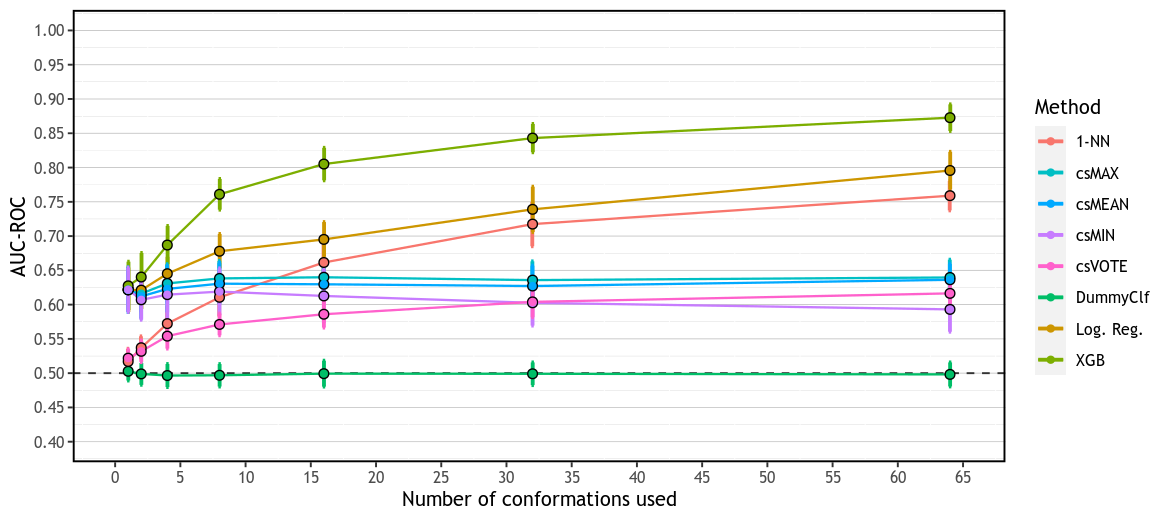

In [18]:
%%R -i full_names -i df_random  -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

df <- df_random
cbbPalette <- hue_pal()(8)
names(cbbPalette) <- full_names

plot_lines(df, cbbPalette, y_min=0.0, y_max=1., line_size=0.6,
               y_label='AUC-ROC', base_h_line=0.5, switch_x=FALSE,
               x_label="Number of conformations used") +
           scale_x_continuous(breaks = seq(0, 65, by = 5), limits=c(0, 65)) +
           scale_y_continuous(breaks = seq(0.4, 1, by = .05), limits=c(0.4, 1))

### NEF R_a

In [19]:
df_random = get_group_stats(full_results[test_name], metric_name='nef_12_Ra', indexes_values=k_values)
df_random = df_random.replace(new_names)

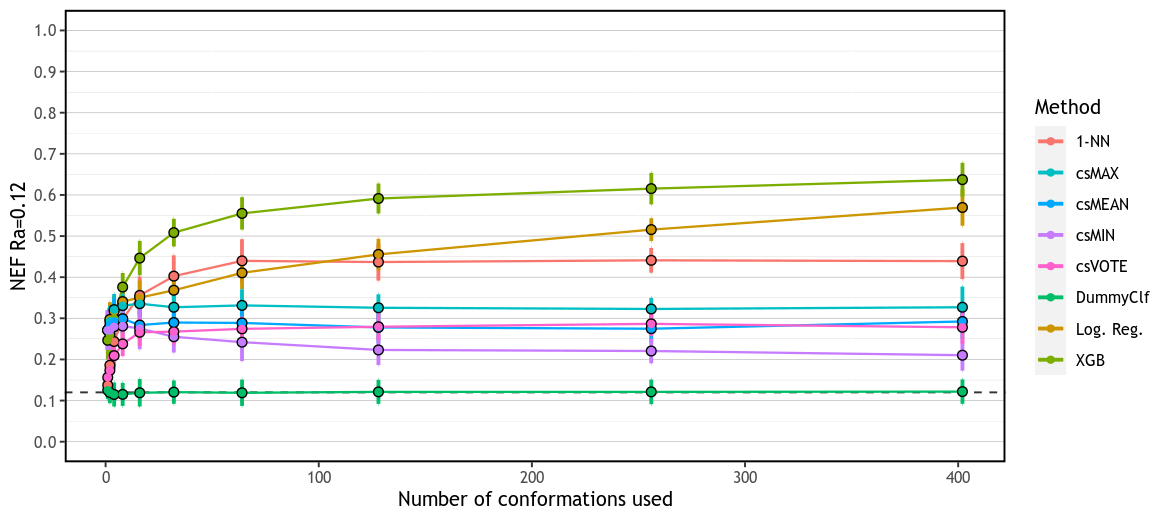

In [20]:
%%R -i full_names -i df_random -i R_a -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')
metric_name <- 'NEF Ra=0.12'

df <- df_random
cbbPalette <- hue_pal()(8)
names(cbbPalette) <- full_names

plot_lines(df, cbbPalette, y_min=0.0, y_max=1., line_size=0.6,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, 
               x_label="Number of conformations used") 

## REF preselected => XGB

In [21]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'XGB_tree'
split = 'random'
filename = f'../6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
rfe_selector.ranking_
df_ranks = pd.DataFrame({'pdb_id': X_merged_dksc.columns, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')

/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RFECV from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [22]:
%%time

# ************
test_name = 'RFExgb'
full_results[test_name] = {}
# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-256
Evaluation with k=256 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_cdk2_nConfs-402
Evaluation with k=402 fi

In [23]:
df_RFExgb = get_group_stats(full_results[test_name], metric_name='roc_auc', indexes_values=k_values)

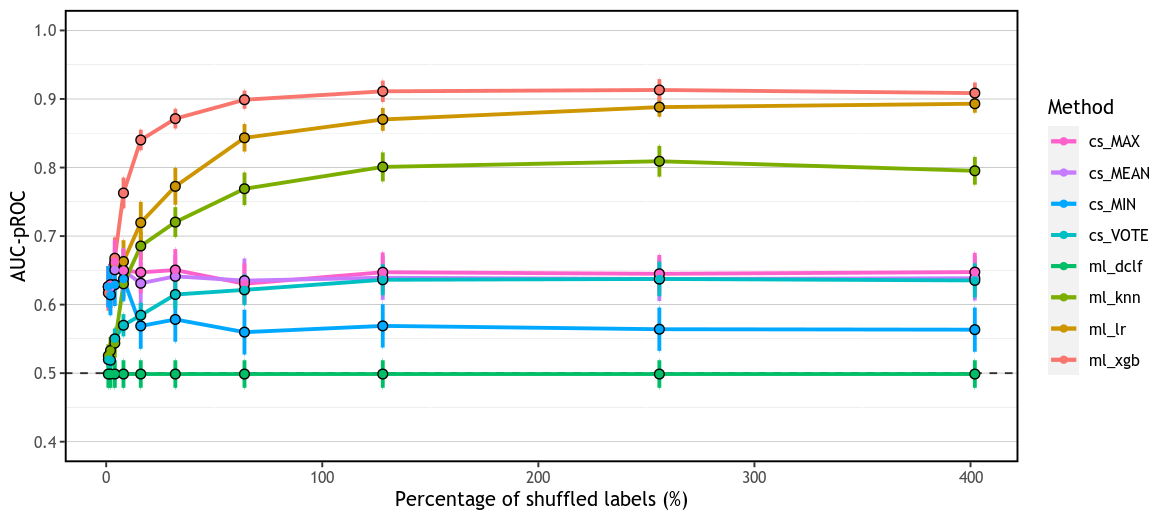

In [24]:
%%R -i df_RFExgb  -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(8)

plot_lines(df_RFExgb, cbbPalette, y_min=0.4, y_max=1., 
               y_label='AUC-pROC', base_h_line=0.5, switch_x=FALSE) 

## Best conformations (single AUC-ROC score)

In [28]:
# Import the conformations features table
file='./TABLE_Confs_Features_and_performances_cdk2.pkl'
with open(file, 'rb') as f:
    df_feat = pickle.load(f)

# Reset index to access each conformation per inx position
df_feat = df_feat.reset_index()

In [29]:
%%time

# ************
test_name = 'singConfAUC'
full_results[test_name] = {}

df_ranks = df_feat.sort_values('AUC-ROC', ascending=False)

# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_cdk2_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_cdk2_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_cdk2_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_cdk2_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_cdk2_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_cdk2_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_cdk2_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_cdk2_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_cdk2_nConfs-256
Evaluation with k=256 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAU

In [30]:
df_singConfAUC = get_group_stats(full_results[test_name], metric_name='roc_auc', indexes_values=k_values)

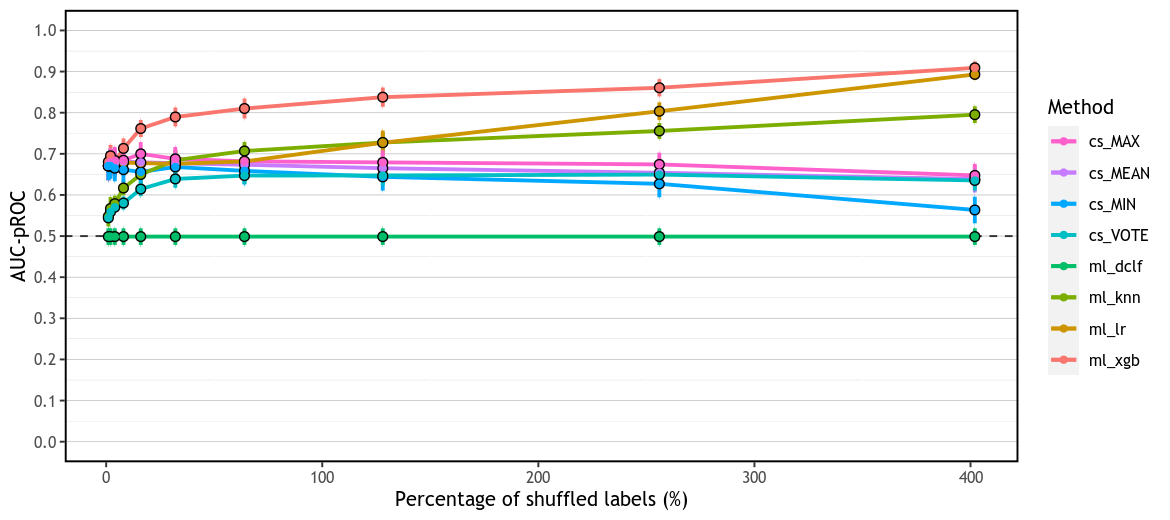

In [31]:
%%R -i df_singConfAUC  -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(8)

plot_lines(df_singConfAUC, cbbPalette, y_min=0.0, y_max=1., 
               y_label='AUC-pROC', base_h_line=0.5, switch_x=FALSE) 

## Conformations from bigger inhibitors

In [32]:
%%time

# ************
test_name = 'bigLigMW'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Inhib. MW', ascending=False)

# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_cdk2_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_cdk2_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_cdk2_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_cdk2_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_cdk2_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_cdk2_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_cdk2_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_cdk2_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_cdk2_nConfs-256
Evaluation with k=256 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_cdk2_nConfs-402
Eval

## Conformations from non or smaller inhibitors

In [33]:
%%time

# ************
test_name = 'smallLigMW'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Inhib. MW', ascending=True)

# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_cdk2_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_cdk2_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_cdk2_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_cdk2_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_cdk2_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_cdk2_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_cdk2_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_cdk2_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_cdk2_nConfs-256
Evaluation with k=256 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_

## Conformations with largest pocket volume

In [34]:
%time

# ************
test_name = 'bigPkVolume'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Pk. Volume', ascending=False)

# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_cdk2_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_cdk2_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_cdk2_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_cdk2_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_cdk2_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_cdk2_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_cdk2_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_cdk2_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_cdk2_nConfs-256
Evaluation with k=

## AUC-ROC

In [35]:
# ROC-AUC
metric_name='roc_auc'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))

display(friedmanTest(ho30.loc[metric_name]))

df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.25, random_state=42)

NameError: name 'ho30' is not defined

In [ ]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 6 -h 4 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.4, y_max=1.) +
add_ref_values('Sing. conf. mean', single_mean, color='cadetblue4') + 
add_ref_values('Sing. conf. max', single_max, color='coral1')

In [ ]:
%%R -i df_R -i full_names -w 6 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

In [ ]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)